### Project Overview
- Domain: Neuroscience / spatial biology
- ML type: Unsupervised learning
- Methods: Standardization → UMAP → HDBSCAN
- Goal: Identify biologically meaningful synapse density clusters

# Clustering of synapses belonging to inhibitory neurons
### *Unsupervised spatial clustering using UMAP + HDBSCAN*

## I. Introduction

* The goal of this project is to use unsupervised machine learning to identify **spatial clustering patterns** of synapses along neuronal dendrites, relative to the soma.  
 
* This analysis focuses on identifying statistically relevant local density clusters across three key analytical levels, utilizing the **UMAP-HDBSCAN** methodology, which is particularly suited for handling the non-spherical, variable-density nature of neural data.

## II. Objectives

* Do the two primary synapse types (asymmetric, excitatory, 'as'; symmetric, inhibitory, 'ss') exhibit distinct spatial clustering patterns across the entire aggregated dataset of nine neurons?  

* Do the synapses belonging to the individual Neuronal Types (Calbindin, Calretinin and Parvalbumin) display distinct, locally confined density clusters (subgroups) along the dendritic arborization relative to the cell body coordinates?

## III. Methodology

1. <u>Preprocessing and Standardization</u>:   
3D coordinates were standardized to ensure that all spatial axes contribute equally to the distance metrics, why standardization matters for distance-based clustering.  

2. <u>Dimensionality Reduction</u>:  
**UMAP** (Uniform Manifold Approximation and Projection) was applied to reduce the 3D data to a 2D manifold, which is critical for preserving the local and global spatial structures necessary for density-based clustering.  
  
3. <u>Clustering</u>:  
**HDBSCAN** (Hierarchical Density-Based Spatial Clustering) was employed due to its robustness in identifying non-spherical, arbitrarily shaped clusters and its ability to manage varying densities without requiring the a priori specification of the number of clusters. The *min_cluster_size* parameter was specifically fine-tuned for each Neuronal Type to ensure the identification of stable, biologically relevant macro-clusters.  



## IV.1 Clustering of historical data

### IV.1.1 About the dataset

* This dataset contains spatial coordinate and morphometric measurements of synapses and boutons from inhibitory neurons.  
* Three neuron types were investigated, with three neurons analyzed per type: calbindin, calretinin, and parvalbumin. (e.g. in total 9)  
* The dataset is based on original measurements and is available upon request.

| Variable          | Description                                                                                                                                         |
| -------------     | ----------------------------------------------------------------------------------------------------------------------------------------------------|
| NeuronId          | abbreviations of calcium-binding containing inhibitory neurons (cb - calbindin; cr - calretining; pv - parvalbumin) with the neuron number (3/type) |
| SynType           | abbreviations of synapse types (as - asymmetric - excitatory synapse; ss - symmetric - inhibitory synapse)                                          |
| SynId             | synapse number                                                                                                                                      |
| x                 | original (raw) synapse center x coordinates                                                                                                         |
| y                 | original (raw) synapse center y coordinates                                                                                                         |
| z                 | original (raw) synapse center z coordinates                                                                                                         |
| soma_x            | original (raw) x coordinates of the soma center                                                                                                     |
| soma_y            | original (raw) y coordinates of the soma center                                                                                                     |
| soma_z            | original (raw) z coordinates of the soma center                                                                                                     |
| corr_x            | corrected synapse center x coordinates in nanometers after applying a spatial correction                                                            |
| corr_y            | corrected synapse center y coordinates in nanometers after applying a spatial correction                                                            |
| corr_z            | corrected synapse center z coordinates in nanometers after applying a spatial correction                                                            |
| corr_soma_x       | corrected soma center x coordinates in nanometers after applying a spatial correction                                                               |
| corr_soma_y       | corrected soma center y coordinates in nanometers after applying a spatial correction                                                               |
| corr_soma_z       | corrected soma center z coordinates in nanometers after applying a spatial correction                                                               |
| SynArea           | area of synapse surface in micron2                                                                                                                  |
| BoutonArea        | area of bouton surface in micron2                                                                                                                   |
| BoutonVolume      | bouton volume in micron3                                                                                                                            |
| corr_x_micron     | corrected synapse center x coordinates converted from nanometers to microns                                                                         |
| corr_y_micron     | corrected synapse center y coordinates converted from nanometers to microns                                                                         |
| corr_z_micron     | corrected synapse center z coordinates converted from nanometers to microns                                                                         |
| corr_soma_x_micron| corrected soma center x coordinates converted from nanometers to microns                                                                            |
| corr_soma_y_micron| corrected soma center y coordinates converted from nanometers to microns                                                                            |
| corr_soma_z_micron| corrected soma center z coordinates converted from nanometers to microns                                                                            |

### IV.1.2 Import the recquired libraries

In [23]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly as py
import plotly.io as pio
import plotly.express as px
import hdbscan
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import splprep, splev
import openpyxl
import lxml
import html5lib
import joblib
import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.path.abspath('src'))
from dimension_reduction import pca_align_one_neuron, make_umap
from cluster import run_hdbscan_umap
from plot import plot_umap_3d, plot_umap_2d, plot_hdbscan_umap_clusters
from train import split_umap_data, knn_with_outlier_filtering, random_forest_with_outlier_filtering

### IV.1.3 Data loading

Load raw CSV dataset

In [3]:
neuron_df = pd.read_excel("neuron_synapse_raw_data.xlsx")

neuron_df.head()

,NeuronId,SynType,SynId,x,y,z,soma_x,soma_y,soma_z,corr_x,...,corr_soma_z,SynArea,BoutonArea,BoutonVolume,corr_x_micron,corr_y_micron,corr_z_micron,corr_soma_x_micron,corr_soma_y_micron,corr_soma_z_micron
0,cb1,as,1,422.4855,389.0125,82.5,847.708,675.18,30,4142.014706,...,294.117647,0.049045,2.420002,0.286752,4.142015,3.813848,0.808824,8.310863,6.619412,0.294118
1,cb1,as,2,450.9020,412.8330,110.0,847.708,675.18,30,4420.607843,...,294.117647,0.101529,1.510073,0.120455,4.420608,4.047382,1.078431,8.310863,6.619412,0.294118
2,cb1,as,3,321.5415,357.7530,197.5,847.708,675.18,30,3152.367647,...,294.117647,0.045333,1.827364,0.257001,3.152368,3.507382,1.936275,8.310863,6.619412,0.294118
3,cb1,as,4,394.7190,376.6410,255.0,847.708,675.18,30,3869.794118,...,294.117647,0.199113,2.487303,0.203978,3.869794,3.692559,2.500000,8.310863,6.619412,0.294118
4,cb1,as,6,383.5580,368.1390,340.0,847.708,675.18,30,3760.372549,...,294.117647,0.140426,2.522674,0.152951,3.760373,3.609206,3.333333,8.310863,6.619412,0.294118


Display the data types

In [4]:
neuron_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   NeuronId            764 non-null    object 
 1   SynType             764 non-null    object 
 2   SynId               764 non-null    int64  
 3   x                   764 non-null    float64
 4   y                   764 non-null    float64
 5   z                   764 non-null    float64
 6   soma_x              764 non-null    float64
 7   soma_y              764 non-null    float64
 8   soma_z              764 non-null    int64  
 9   corr_x              764 non-null    float64
 10  corr_y              764 non-null    float64
 11  corr_z              764 non-null    float64
 12  corr_soma_x         764 non-null    float64
 13  corr_soma_y         764 non-null    float64
 14  corr_soma_z         764 non-null    float64
 15  SynArea             764 non-null    float64
 16  BoutonAr

### IV.1.4 Data Preparation and Feature Engineering

creation of [NeuronType] column (additional label in order to separate the three neuron types)

In [5]:
conditions = [
    neuron_df['NeuronId'].isin(['cb1', 'cb2', 'cb3']),  # Calbindin neurons
    neuron_df['NeuronId'].isin(['cr1', 'cr2', 'cr3']),  # Calretinin neurons
    neuron_df['NeuronId'].isin(['pv1', 'pv2', 'pv3'])   # Parvalbumin neurons
]

choices = [
    'calbindin',
    'calretinin',
    'parvalbumin'
]

neuron_df['NeuronType'] = np.select(conditions, choices, default='other')

neuron_df.head()

,NeuronId,SynType,SynId,x,y,z,soma_x,soma_y,soma_z,corr_x,...,SynArea,BoutonArea,BoutonVolume,corr_x_micron,corr_y_micron,corr_z_micron,corr_soma_x_micron,corr_soma_y_micron,corr_soma_z_micron,NeuronType
0,cb1,as,1,422.4855,389.0125,82.5,847.708,675.18,30,4142.014706,...,0.049045,2.420002,0.286752,4.142015,3.813848,0.808824,8.310863,6.619412,0.294118,calbindin
1,cb1,as,2,450.9020,412.8330,110.0,847.708,675.18,30,4420.607843,...,0.101529,1.510073,0.120455,4.420608,4.047382,1.078431,8.310863,6.619412,0.294118,calbindin
2,cb1,as,3,321.5415,357.7530,197.5,847.708,675.18,30,3152.367647,...,0.045333,1.827364,0.257001,3.152368,3.507382,1.936275,8.310863,6.619412,0.294118,calbindin
3,cb1,as,4,394.7190,376.6410,255.0,847.708,675.18,30,3869.794118,...,0.199113,2.487303,0.203978,3.869794,3.692559,2.500000,8.310863,6.619412,0.294118,calbindin
4,cb1,as,6,383.5580,368.1390,340.0,847.708,675.18,30,3760.372549,...,0.140426,2.522674,0.152951,3.760373,3.609206,3.333333,8.310863,6.619412,0.294118,calbindin


In [6]:
neuron_df.NeuronId.value_counts().sort_index()

NeuronId
cb1    107
cb2     36
cb3      6
cr1     42
cr2     49
cr3     28
pv1     68
pv2    178
pv3    250
Name: count, dtype: int64

In [7]:
neuron_df.NeuronType.value_counts().sort_index()

NeuronType
calbindin      149
calretinin     119
parvalbumin    496
Name: count, dtype: int64

In [8]:
neuron_df.SynType.value_counts().sort_index()

SynType
as    643
ss    121
Name: count, dtype: int64

In [9]:
neuron_df = neuron_df[['NeuronType', 'NeuronId', 'SynType', 'SynId', 'corr_x_micron', 'corr_y_micron', 'corr_z_micron', 'corr_soma_x_micron', 'corr_soma_y_micron', 'corr_soma_z_micron', 'SynArea', 'BoutonArea', 'BoutonVolume']]

neuron_df.head(5)

,NeuronType,NeuronId,SynType,SynId,corr_x_micron,corr_y_micron,corr_z_micron,corr_soma_x_micron,corr_soma_y_micron,corr_soma_z_micron,SynArea,BoutonArea,BoutonVolume
0,calbindin,cb1,as,1,4.142015,3.813848,0.808824,8.310863,6.619412,0.294118,0.049045,2.420002,0.286752
1,calbindin,cb1,as,2,4.420608,4.047382,1.078431,8.310863,6.619412,0.294118,0.101529,1.510073,0.120455
2,calbindin,cb1,as,3,3.152368,3.507382,1.936275,8.310863,6.619412,0.294118,0.045333,1.827364,0.257001
3,calbindin,cb1,as,4,3.869794,3.692559,2.500000,8.310863,6.619412,0.294118,0.199113,2.487303,0.203978
4,calbindin,cb1,as,6,3.760373,3.609206,3.333333,8.310863,6.619412,0.294118,0.140426,2.522674,0.152951


**Spatial Coordinate Normalization**: Translation of synapse coordinates to a common origin (0, 0, 0)

In [10]:
df = neuron_df

df["zero_corr_x"] = df["corr_x_micron"] - df["corr_soma_x_micron"]
df["zero_corr_y"] = df["corr_y_micron"] - df["corr_soma_y_micron"]
df["zero_corr_z"] = df["corr_z_micron"] - df["corr_soma_z_micron"]

df.head(5)

,NeuronType,NeuronId,SynType,SynId,corr_x_micron,corr_y_micron,corr_z_micron,corr_soma_x_micron,corr_soma_y_micron,corr_soma_z_micron,SynArea,BoutonArea,BoutonVolume,zero_corr_x,zero_corr_y,zero_corr_z
0,calbindin,cb1,as,1,4.142015,3.813848,0.808824,8.310863,6.619412,0.294118,0.049045,2.420002,0.286752,-4.168848,-2.805564,0.514706
1,calbindin,cb1,as,2,4.420608,4.047382,1.078431,8.310863,6.619412,0.294118,0.101529,1.510073,0.120455,-3.890255,-2.572029,0.784314
2,calbindin,cb1,as,3,3.152368,3.507382,1.936275,8.310863,6.619412,0.294118,0.045333,1.827364,0.257001,-5.158495,-3.112029,1.642157
3,calbindin,cb1,as,4,3.869794,3.692559,2.500000,8.310863,6.619412,0.294118,0.199113,2.487303,0.203978,-4.441069,-2.926853,2.205882
4,calbindin,cb1,as,6,3.760373,3.609206,3.333333,8.310863,6.619412,0.294118,0.140426,2.522674,0.152951,-4.550490,-3.010206,3.039216


Selection of relevant spatial and morphometric features

In [11]:
neuron_df_final=neuron_df[['NeuronType', 'NeuronId', 'SynType', 'SynId', 'zero_corr_x', 'zero_corr_y', 'zero_corr_z', 'SynArea', 'BoutonArea', 'BoutonVolume']]

neuron_df_final.head(5)

,NeuronType,NeuronId,SynType,SynId,zero_corr_x,zero_corr_y,zero_corr_z,SynArea,BoutonArea,BoutonVolume
0,calbindin,cb1,as,1,-4.168848,-2.805564,0.514706,0.049045,2.420002,0.286752
1,calbindin,cb1,as,2,-3.890255,-2.572029,0.784314,0.101529,1.510073,0.120455
2,calbindin,cb1,as,3,-5.158495,-3.112029,1.642157,0.045333,1.827364,0.257001
3,calbindin,cb1,as,4,-4.441069,-2.926853,2.205882,0.199113,2.487303,0.203978
4,calbindin,cb1,as,6,-4.550490,-3.010206,3.039216,0.140426,2.522674,0.152951


### IV.1.5 Exploratory data analysis

**Descriptive Statistic**

In [11]:
neuron_df_final.describe()

,SynId,zero_corr_x,zero_corr_y,zero_corr_z,SynArea,BoutonArea,BoutonVolume
count,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000
mean,59.289267,1.728605,-4.015463,16.354840,0.054154,1.571179,0.122258
std,57.916298,5.298795,7.718734,14.275521,0.034179,0.995622,0.106488
min,1.000000,-11.285920,-26.405550,-1.125000,0.004907,0.186348,0.004683
25%,15.000000,-1.558610,-10.690162,5.968750,0.030581,0.912955,0.050172
50%,35.000000,1.372790,-1.247608,11.475000,0.045692,1.298975,0.088068
75%,92.000000,4.630424,1.501605,23.295711,0.066687,1.961070,0.159218
max,225.000000,28.749231,7.242210,56.495098,0.247606,7.943580,0.846982


**Pairwise Feature Relationships**: Visual inspection of potential clustering patterns

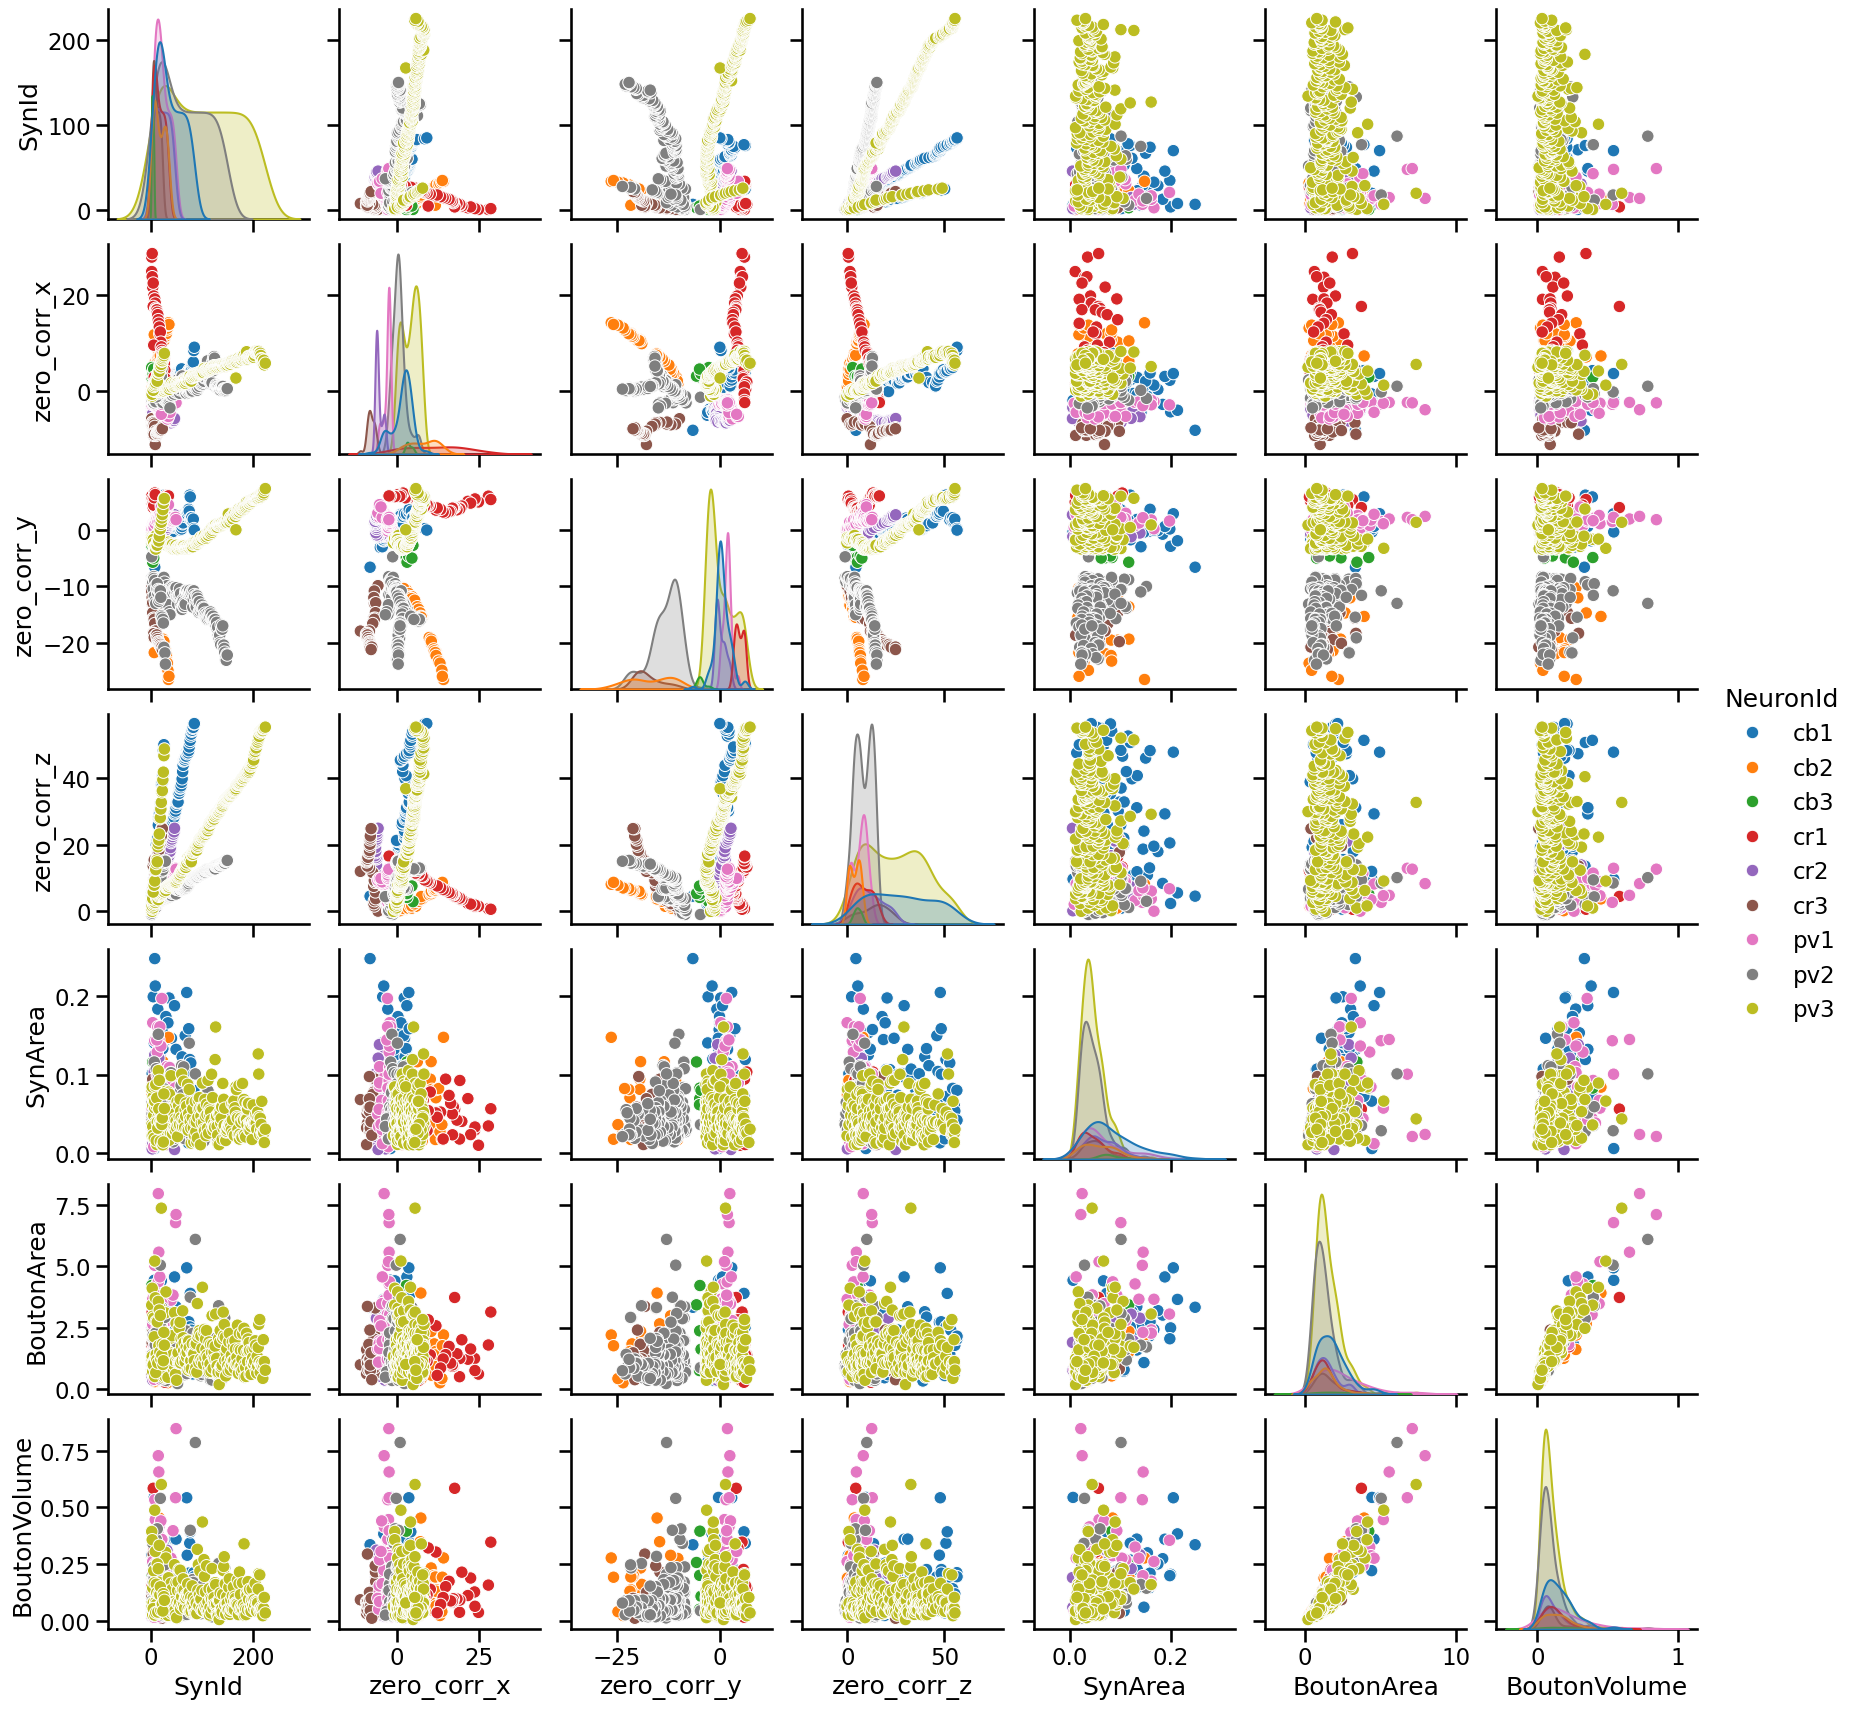

In [12]:
neuron_order = ['cb1', 'cb2', 'cb3',
                'cr1', 'cr2', 'cr3',
                'pv1', 'pv2', 'pv3']

base_palette = sns.color_palette('tab10', len(neuron_order))
NEURON_COLORS = dict(zip(neuron_order, base_palette))

sns.set_context('talk')

sns.pairplot(
    neuron_df_final,
    hue='NeuronId',
    hue_order=neuron_order,
    palette=NEURON_COLORS
)

* Diagonal plots show non-normal distributions of individual features.  
* BoutonArea and BoutonVolume are strongly correlated; therefore, BoutonVolume may be omitted in future feature selection steps.  
* Neurons exhibit different spatial orientations as reflected by their coordinate values.

**Correlation Analysis**

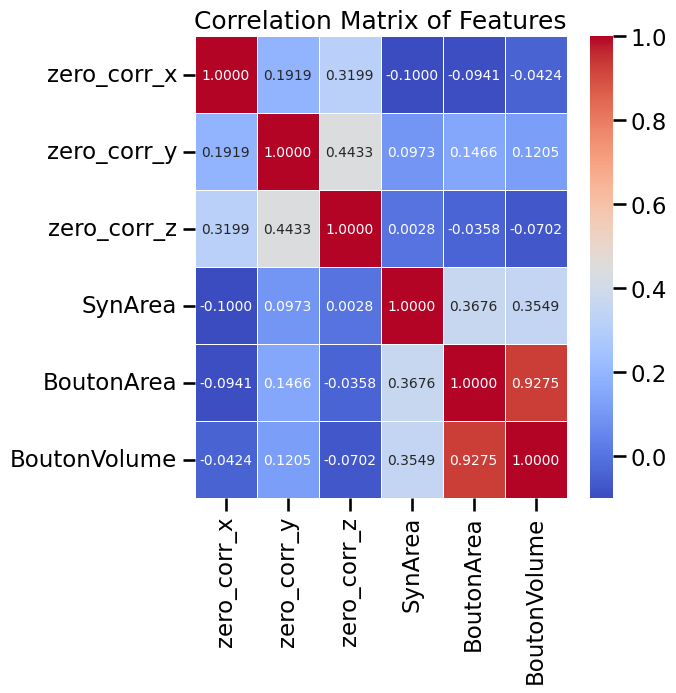

In [13]:
columns_list = ['zero_corr_x', 'zero_corr_y', 'zero_corr_z', 'SynArea', 'BoutonArea', 'BoutonVolume'] 

correlation_matrix = neuron_df_final[columns_list].corr() 

plt.figure(figsize=(6, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    annot_kws={"size": 10},
    cmap='coolwarm',
    fmt='.4f',
    linewidths=0.5,
    cbar=True
)

plt.title('Correlation Matrix of Features')
plt.show()

A strong correlation between BoutonVolume and BoutonArea is revealed by the correlation analysis.

### IV.1.6 Morphometric Feature Cleaning and Outlier Filtering

Identification and Removing of extreme outliers in morphometric features

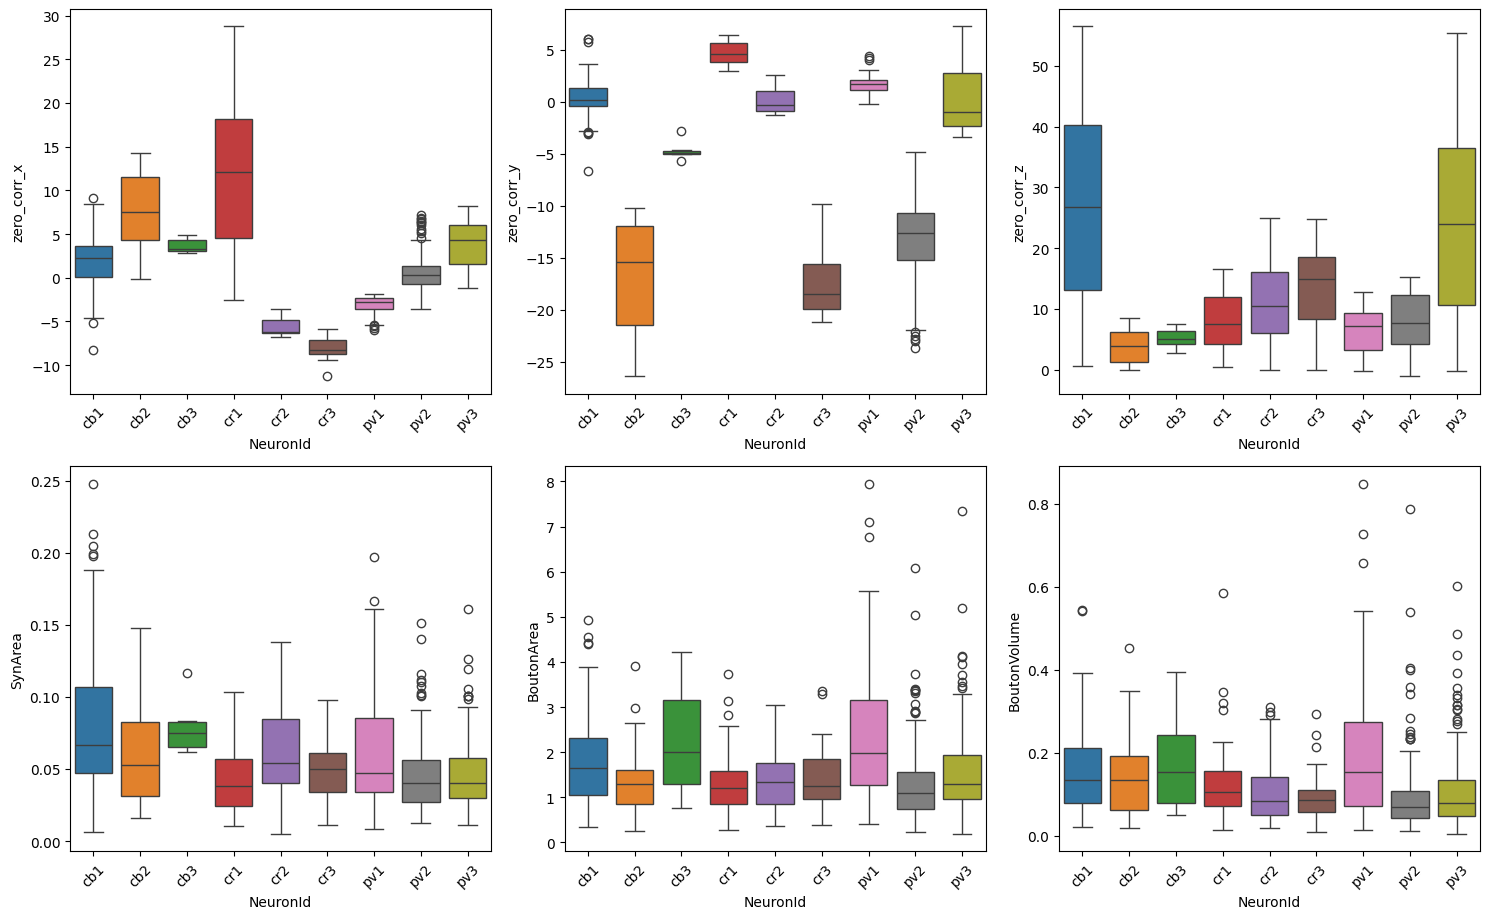

In [14]:
sns.set_context('notebook')
plt.style.use('default')

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

columns_to_box = ['zero_corr_x', 'zero_corr_y', 'zero_corr_z',
                  'SynArea', 'BoutonArea', 'BoutonVolume']

neuron_order = ['cb1', 'cb2', 'cb3', 'cr1', 'cr2', 'cr3', 'pv1', 'pv2', 'pv3']
base_palette = sns.color_palette('tab10', len(neuron_order))
NEURON_COLORS = dict(zip(neuron_order, base_palette))

neuron_ids = sorted(neuron_df_final['NeuronId'].unique())
palette = sns.color_palette('tab10', len(neuron_ids))
color_map = dict(zip(neuron_ids, palette))   

for ax, col in zip(axes, columns_to_box):
    sns.boxplot(
        data=neuron_df_final,
        x='NeuronId',
        y=col,
        ax=ax,
        order=neuron_order,
        palette=NEURON_COLORS  
    )
    # ax.set_title(col, fontsize=12)
    ax.set_xlabel('NeuronId')
    ax.tick_params(axis='x', rotation=45)

fig.tight_layout(rect=[0, 0.05, 1, 0.98])
plt.show()

In [15]:
columns_to_check = ['SynArea', 'BoutonArea']

extreme_outlier_indices = set()

df_temp = neuron_df_final.copy()

for col in columns_to_check:
    # IQR calculation
    Q1 = df_temp[col].quantile(0.25)
    Q3 = df_temp[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Extreme outlier thresholds (3 * IQR rule)
    lower_bound_extreme = Q1 - 3 * IQR
    upper_bound_extreme = Q3 + 3 * IQR
    
    # Find indices of extreme outliers
    outlier_rows = df_temp[
        (df_temp[col] < lower_bound_extreme) | 
        (df_temp[col] > upper_bound_extreme)
    ]
    
    # Add indices to the set
    extreme_outlier_indices.update(outlier_rows.index)

# Create the neuron_df_filtered DataFrame: remove the collected indices
# The ~ (tilde) operator inverts the selection (select rows that are NOT outliers)
neuron_df_filtered = df_temp.drop(index=list(extreme_outlier_indices))

removed_count = len(neuron_df_final) - len(neuron_df_filtered)
print(f"Original count: {len(neuron_df_final)}")
print(f"Removed entries (SynArea/BoutonArea extreme outliers): {removed_count}")
print(f"Filtered count (neuron_df_filtered): {len(neuron_df_filtered)}")

# --- 2. Standardization ---

# Select numeric columns for standardization (BoutonVolume excluded)
numeric_cols_for_std = [
    'zero_corr_x', 'zero_corr_y', 'zero_corr_z', 
    'SynArea', 'BoutonArea'
]

# Create the scaler object
scaler = StandardScaler()

# Perform standardization on numeric columns of the filtered dataset
X_scaled = scaler.fit_transform(neuron_df_filtered[numeric_cols_for_std])

# Create the neuron_df_std DataFrame
# This DataFrame contains the standardized values
neuron_df_std = pd.DataFrame(X_scaled, columns=numeric_cols_for_std)

# Add identifier columns to neuron_df_std
id_cols = ['NeuronType', 'NeuronId', 'SynType', 'SynId']
for col in id_cols:
    # Align DataFrame indices before adding identifier columns
    neuron_df_std[col] = neuron_df_filtered[col].reset_index(drop=True)

print("\n--- neuron_df_std (Standardized DataFrame) ---")
print(neuron_df_std.head())


Original count: 764
Removed entries (SynArea/BoutonArea extreme outliers): 16
Filtered count (neuron_df_filtered): 748

--- neuron_df_std (Standardized DataFrame) ---
   zero_corr_x  zero_corr_y  zero_corr_z   SynArea  BoutonArea NeuronType  \
0    -1.123107     0.164745    -1.111694 -0.109783    1.097166  calbindin   
1    -1.070625     0.194843    -1.092841  1.615180    0.011771  calbindin   
2    -1.309539     0.125249    -1.032852 -0.231781    0.390247  calbindin   
3    -1.195002     0.138372    -0.935156  2.893570    1.219637  calbindin   
4    -1.166854     0.294053    -0.732907  0.023975   -0.043113  calbindin   

  NeuronId SynType  SynId  
0      cb1      as      1  
1      cb1      as      2  
2      cb1      as      3  
3      cb1      as      6  
4      cb1      ss      2  


**3D Spatial Visualization of Synapses**: 3D visualization of synapse positions per neuron

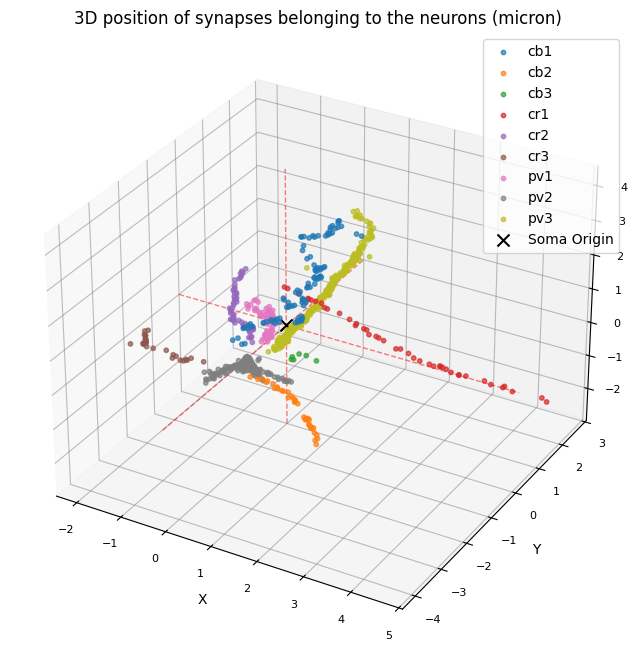

In [16]:
df = neuron_df_std

neuron_order = ['cb1', 'cb2', 'cb3', 'cr1', 'cr2', 'cr3', 'pv1', 'pv2', 'pv3']

base_palette = sns.color_palette('tab10', len(neuron_order))
NEURON_COLORS = dict(zip(neuron_order, base_palette))

neurons = df["NeuronId"].unique()   

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for nid in neurons:
    color = NEURON_COLORS.get(nid, 'gray')
    sub = df[df["NeuronId"] == nid]
    ax.scatter(
        sub["zero_corr_x"],
        sub["zero_corr_y"],
        sub["zero_corr_z"],
        label=str(nid),
        s=10,
        alpha=0.7,
        color=color   
    )

ax.set_title("3D position of synapses belonging to the neurons (micron)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.scatter(
    0, 0, 0,
    s=75,
    marker='x',
    color='black',
    label='Soma Origin'
)

ax.legend()
ax.tick_params(axis='both', which='major', labelsize=8)

ax.xaxis._axinfo['grid']['color'] = (0.5, 0.5, 0.5, 0.5)
ax.yaxis._axinfo['grid']['color'] = (0.5, 0.5, 0.5, 0.5)
ax.zaxis._axinfo['grid']['color'] = (0.5, 0.5, 0.5, 0.5)

x = df["zero_corr_x"]
y = df["zero_corr_y"]
z = df["zero_corr_z"]
max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max() / 2.0

mid_x = (x.max()+x.min()) * 0.5
mid_y = (y.max()+y.min()) * 0.5
mid_z = (z.max()+z.min()) * 0.5

ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

ax.plot([0, 0], [0, 0], zs=[mid_z - max_range, mid_z + max_range],
        color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.plot([0, 0], ys=[mid_y - max_range, mid_y + max_range], zs=[0, 0],
        color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.plot(xs=[mid_x - max_range, mid_x + max_range], ys=[0, 0], zs=[0, 0],
        color='red', linestyle='--', linewidth=1, alpha=0.5)

plt.show()


### IV.1.7 Linear Dimensionality Reduction  

**Principal Component Analysis (PCA)-Based Spatial Alignment**: Alignment of principal axes across neurons

In [17]:
pca_models = {}
transformed_groups = []

for neuron_id, group in neuron_df_std.groupby('NeuronId'):
    transformed, pca_model = pca_align_one_neuron(group)
    transformed_groups.append(transformed)
    pca_models[neuron_id] = pca_model

# Merge with the transform data
neuron_df_pca = pd.concat(transformed_groups, ignore_index=True)

In [18]:
joblib.dump(pca_models, "pca_models_per_neuronid.pkl")

['pca_models_per_neuronid.pkl']

Visualization of PCA-aligned synapse distributions

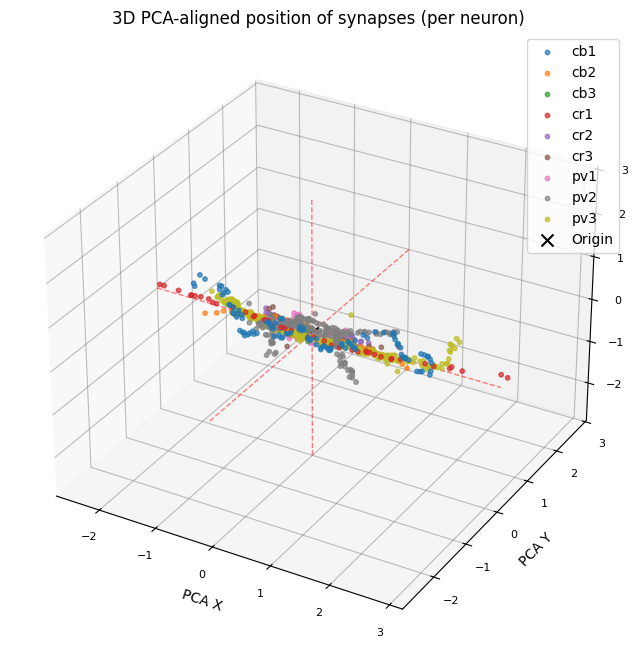

In [19]:
df = neuron_df_pca

neuron_order = ['cb1', 'cb2', 'cb3', 'cr1', 'cr2', 'cr3', 'pv1', 'pv2', 'pv3']

base_palette = sns.color_palette('tab10', len(neuron_order))
NEURON_COLORS = dict(zip(neuron_order, base_palette))

neurons = df["NeuronId"].unique()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for nid in neurons:

    color = NEURON_COLORS.get(nid, 'gray')
    sub = df[df["NeuronId"] == nid]
    ax.scatter(
        sub["pca_x"],      
        sub["pca_y"],
        sub["pca_z"],
        label=str(nid),
        s=10,
        alpha=0.7,
        color=color
    )

ax.set_title("3D PCA-aligned position of synapses (per neuron)")
ax.set_xlabel("PCA X")
ax.set_ylabel("PCA Y")
ax.set_zlabel("PCA Z")

# Origin marker (origin of the PCA space, not necessarily the soma position)
ax.scatter(
    0, 0, 0,
    s=75,
    marker='x',
    color='black',
    label='Origin'
)

ax.legend()
ax.tick_params(axis='both', which='major', labelsize=8)

ax.xaxis._axinfo['grid']['color'] = (0.5, 0.5, 0.5, 0.5)
ax.yaxis._axinfo['grid']['color'] = (0.5, 0.5, 0.5, 0.5)
ax.zaxis._axinfo['grid']['color'] = (0.5, 0.5, 0.5, 0.5)

# Setting equal axis boundaries based on PCA coordinates for proportional scaling
x = df["pca_x"]
y = df["pca_y"]
z = df["pca_z"]
max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max() / 2.0

mid_x = (x.max()+x.min()) * 0.5
mid_y = (y.max()+y.min()) * 0.5
mid_z = (z.max()+z.min()) * 0.5

ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

# Auxiliary reference axes (in PCA space)
ax.plot([0, 0], [0, 0],
        zs=[mid_z - max_range, mid_z + max_range],
        color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.plot([0, 0],
        ys=[mid_y - max_range, mid_y + max_range],
        zs=[0, 0],
        color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.plot(xs=[mid_x - max_range, mid_x + max_range],
        ys=[0, 0], zs=[0, 0],
        color='red', linestyle='--', linewidth=1, alpha=0.5)

plt.show()


In [20]:
neuron_df_pca.head()

,zero_corr_x,zero_corr_y,zero_corr_z,SynArea,BoutonArea,NeuronType,NeuronId,SynType,SynId,pca_x,pca_y,pca_z
0,-1.123107,0.164745,-1.111694,-0.109783,1.097166,calbindin,cb1,as,1,-2.254214,0.230884,0.159043
1,-1.070625,0.194843,-1.092841,1.615180,0.011771,calbindin,cb1,as,2,-2.212435,0.194389,0.128411
2,-1.309539,0.125249,-1.032852,-0.231781,0.390247,calbindin,cb1,as,3,-2.260374,0.424595,0.229550
3,-1.195002,0.138372,-0.935156,2.893570,1.219637,calbindin,cb1,as,6,-2.125064,0.357483,0.224796
4,-1.166854,0.294053,-0.732907,0.023975,-0.043113,calbindin,cb1,ss,2,-1.908107,0.430261,0.108321


### IV.1.8 Feature Scaling  

RobustScaler was used instead of StandardScaler because several spatial and morphometric features exhibit non-normal, skewed distributions and may still contain residual extreme values, even after outlier filtering.

In [21]:
coord_cols = ['pca_x', 'pca_y', 'pca_z', 'SynArea', 'BoutonArea']

X = neuron_df_pca[coord_cols]

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

joblib.dump(scaler, "robust_scaler.pkl")

['robust_scaler.pkl']

### IV.1.9 Dimensionality Reduction with Uniform Manifold Approximation and Projection (UMAP)

Morphometric features (SynArea and BoutonArea) were weighted tenfold relative to spatial coordinates by all umap applications, as preliminary analyses revealed substantial differences in neuron orientation even after PCA-based alignment.  

#### IV.1.9.1 **UMAP embedding of excitatory ('as') synapses**

A two-dimensional UMAP embedding (n_components = 2) provided the best separation of clusters while maintaining clear identification of noise points.

In [27]:
df_umap_as, umap_as_model = make_umap(
    neuron_df_pca,
    syn_type='as',
    neuron_type=None,
    coord_weight=0.1,
    morph_weight=1.0,
    n_components=2
)

joblib.dump(umap_as_model, "umap_as_model.pkl")

Running UMAP (SynType=as, NeuronType=None, coord_w=0.1, morph_w=1.0, n_comp=2, n_neighbors=20, min_dist=0.1)


['umap_as_model.pkl']

UMAP visualisation of excitatory ('as') synapses

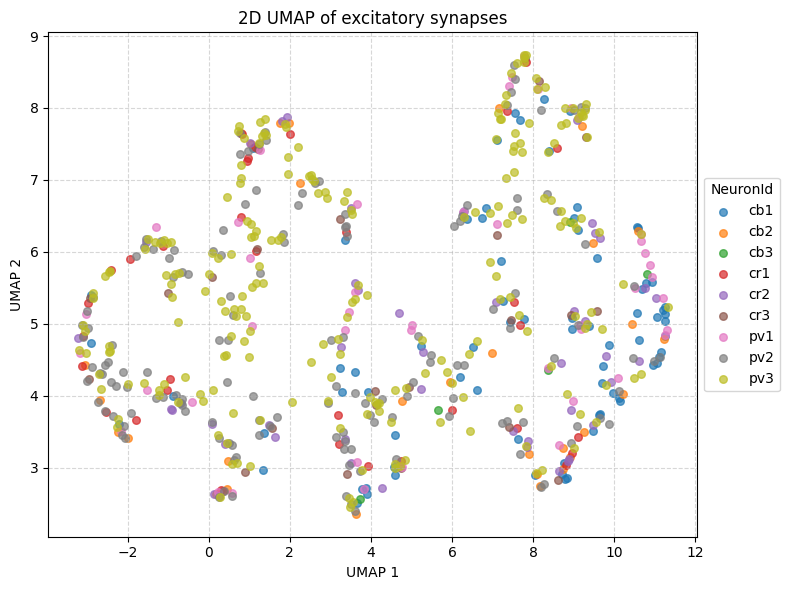

In [28]:
plot_umap_2d(df_umap_as, title='2D UMAP of excitatory synapses')

#### IV.1.9.2 **UMAP embedding of inhibitory ('ss') synapses**

A two-dimensional UMAP embedding (n_components = 2) provided the best separation of clusters while maintaining clear identification of noise points.

In [31]:
df_umap_ss, umap_ss_model = make_umap(
    neuron_df_pca,
    syn_type='ss',
    neuron_type=None,
    coord_weight=0.1,
    morph_weight=1.0,
    n_components=2
)

joblib.dump(umap_ss_model, "umap_ss_model.pkl")

Running UMAP (SynType=ss, NeuronType=None, coord_w=0.1, morph_w=1.0, n_comp=2, n_neighbors=20, min_dist=0.1)


['umap_ss_model.pkl']

UMAP visualisation of inhibitory ('ss') synapses

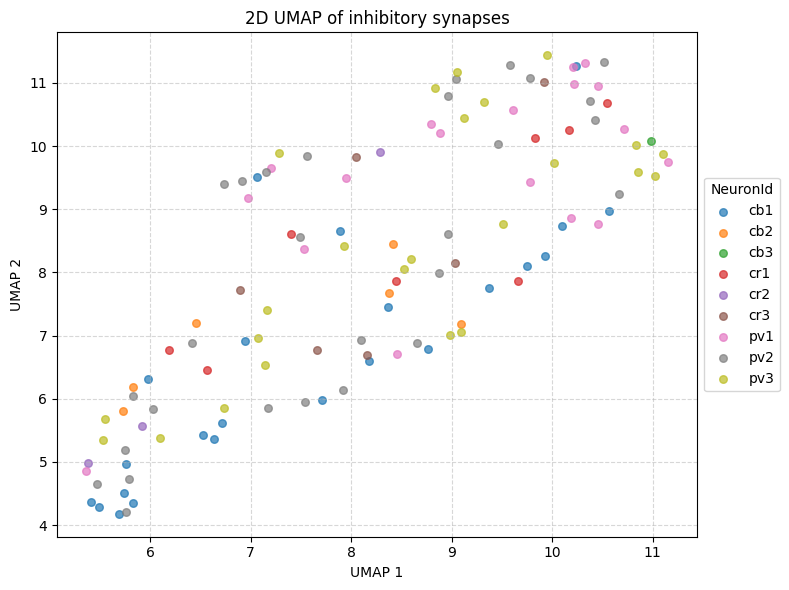

In [32]:
plot_umap_2d(df_umap_ss, title='2D UMAP of inhibitory synapses')

#### IV.1.9.3 **UMAP embedding of calbindin-immunopositive ('cb') synapses**

A two-dimensional UMAP embedding (n_components = 2) provided the best separation of clusters while maintaining clear identification of noise points.

In [34]:
df_umap_cb, umap_cb_model = make_umap(
    neuron_df_pca,
    neuron_type='calbindin',
    coord_weight=0.1,
    morph_weight=1.0,
    n_components=2
)

joblib.dump(umap_cb_model, "umap_cb_model.pkl")

Running UMAP (SynType=None, NeuronType=calbindin, coord_w=0.1, morph_w=1.0, n_comp=2, n_neighbors=20, min_dist=0.1)


['umap_cb_model.pkl']

UMAP visualisation of calbindin-immunopositive ('cb') synapses

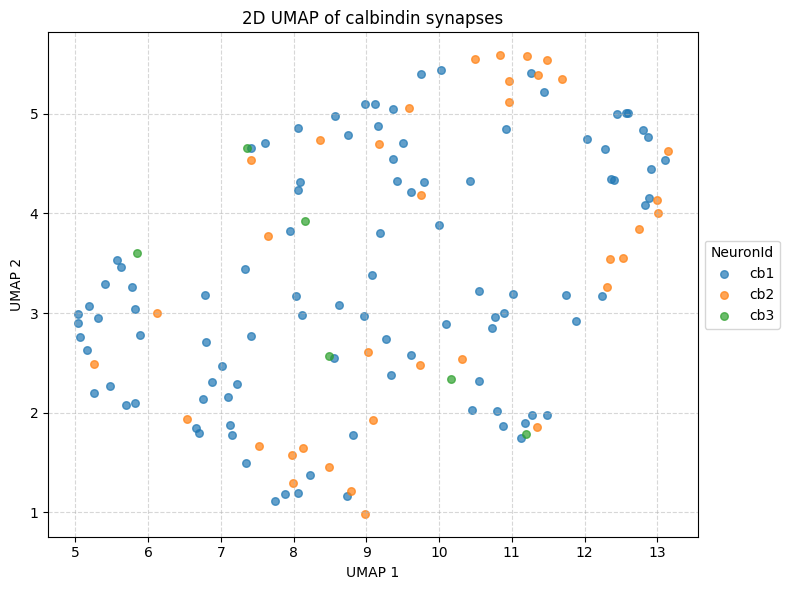

In [26]:
plot_umap_2d(df_umap_cb, title='2D UMAP of calbindin synapses')

#### IV.1.9.4 **UMAP embedding of calretinin-immunopositive ('cr') synapses**

In this case, a three-dimensional UMAP embedding (n_components = 3) provided the best separation of clusters while maintaining clear identification of noise points.

In [35]:
df_umap_cr, umap_cr_model = make_umap(
    neuron_df_pca,
    neuron_type='calretinin',
    coord_weight=0.1,
    morph_weight=1.0,
    n_components=3
)

joblib.dump(umap_cr_model, "umap_cr_model.pkl")

Running UMAP (SynType=None, NeuronType=calretinin, coord_w=0.1, morph_w=1.0, n_comp=3, n_neighbors=20, min_dist=0.1)


['umap_cr_model.pkl']

UMAP visualisation of calretinin-immunopositive ('cr') synapses

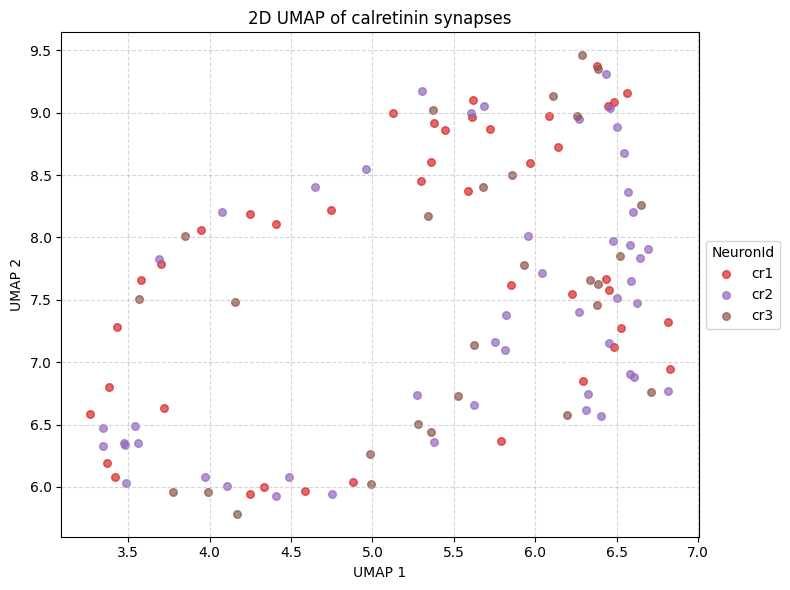

In [36]:
plot_umap_2d(df_umap_cr, title='2D UMAP of calretinin synapses')

#### IV.1.9.5 **UMAP embedding of parvalbumin-immunopositive ('pv') synapses**

A two-dimensional UMAP embedding (n_components = 2) provided the best separation of clusters while maintaining clear identification of noise points.

In [37]:
df_umap_pv, umap_pv_model = make_umap(
    neuron_df_pca,
    neuron_type='parvalbumin',
    coord_weight=0.1,
    morph_weight=1.0,
    n_components=2
)

joblib.dump(umap_pv_model, "umap_pv_model.pkl")

Running UMAP (SynType=None, NeuronType=parvalbumin, coord_w=0.1, morph_w=1.0, n_comp=2, n_neighbors=20, min_dist=0.1)


['umap_pv_model.pkl']

UMAP visualisation of parvalbumin-immunopositive ('pv') synapses

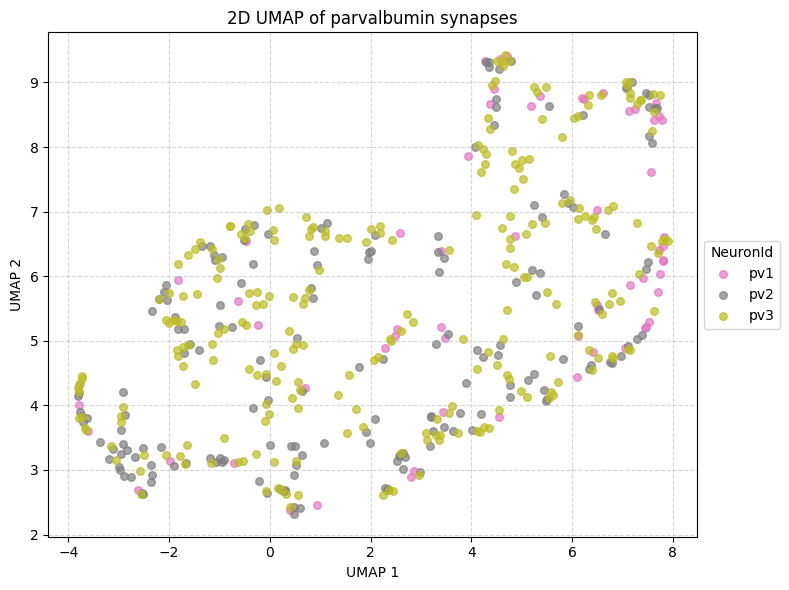

In [38]:
plot_umap_2d(df_umap_pv, title='2D UMAP of parvalbumin synapses')

### IV.1.10 Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN)

#### IV.1.10.1 **Clustering of excitatory ('as') synapses with HDBSCAN**

* *min_cluster_size*: This value was selected relative to the sample size (n) to avoid identifying small, potentially spurious groups as clusters and to focus on robust, biologically meaningful structures.  

* *min_samples*: A higher value increases robustness to noise, while still allowing clusters of varying density to be detected.

In [39]:
df_cluster, clusterer = run_hdbscan_umap(
    umap_df_source=df_umap_as,
    min_cluster_size=40,
    min_samples=12
)

cols = ['SynId', 'NeuronType', 'NeuronId', 'SynType', 'UMAP_1', 'UMAP_2', 'Cluster']
as_cluster_final = df_cluster[cols].copy()
as_cluster_final['clusterid'] = 'as'

HDBSCAN: dim=2D, clusters=4, noise=27, min_cluster_size=40, min_samples=12


HDBSCAN visualisation of excitatory ('as') synapses

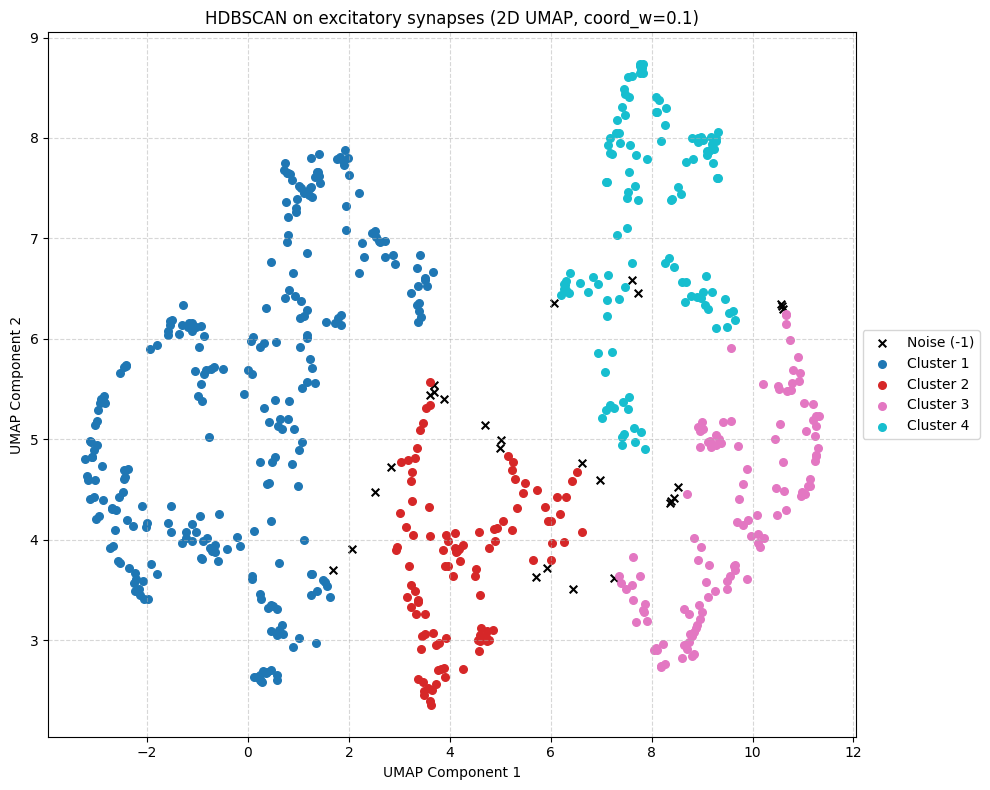

In [40]:
plot_hdbscan_umap_clusters(
    df_cluster,
    title="HDBSCAN on excitatory synapses (2D UMAP, coord_w=0.1)"
)

#### IV.1.10.2 **Clustering of inhibitory ('ss') synapses with HDBSCAN**

* *min_cluster_size*: This value was selected relative to the sample size (n) to avoid identifying small, potentially spurious groups as clusters and to focus on robust, biologically meaningful structures.  

* *min_samples*: A lower min_samples value was used to accommodate lower local density and higher structural variability in the UMAP embedding.

In [41]:
df_cluster, clusterer = run_hdbscan_umap(
    umap_df_source=df_umap_ss,
    min_cluster_size=11,
    min_samples=3
)

cols = ['SynId', 'NeuronType', 'NeuronId', 'SynType', 'UMAP_1', 'UMAP_2', 'Cluster']
ss_cluster_final = df_cluster[cols].copy()
ss_cluster_final['clusterid'] = 'ss'

HDBSCAN: dim=2D, clusters=4, noise=8, min_cluster_size=11, min_samples=3


HDBSCAN visualisation of inhibitory ('ss') synapses

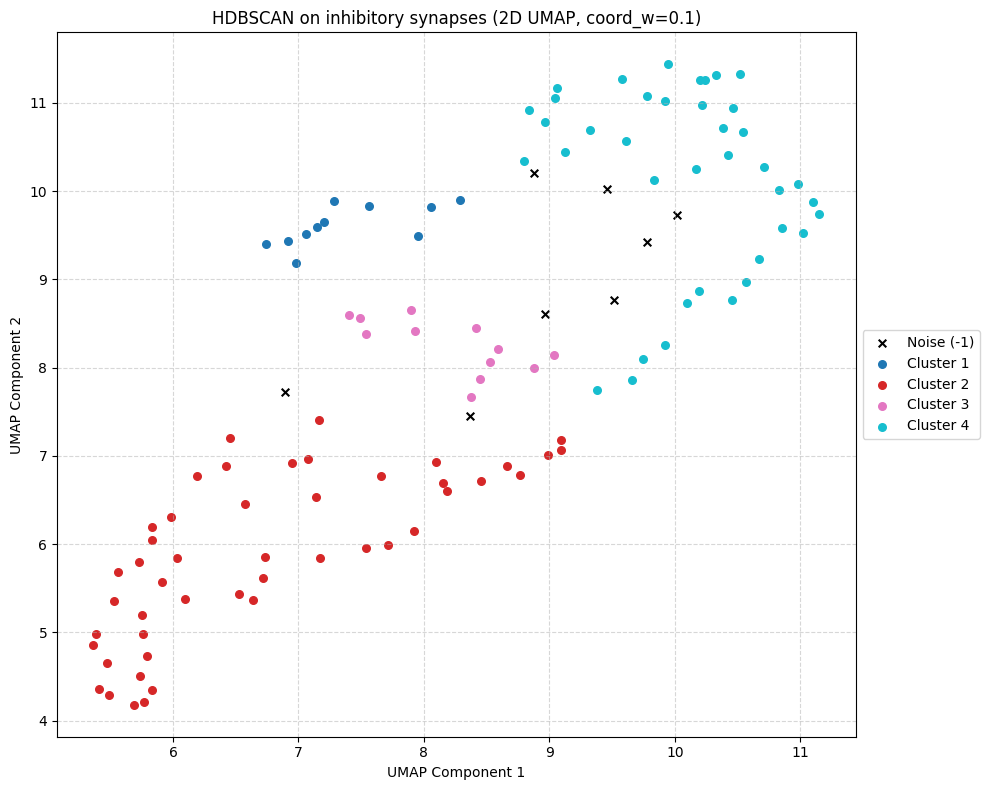

In [42]:
plot_hdbscan_umap_clusters(
    df_cluster,
    title="HDBSCAN on inhibitory synapses (2D UMAP, coord_w=0.1)"
)

#### IV.1.10.3 **Clustering of calbindin ('cb') synapses with HDBSCAN**

* *min_cluster_size*: This value was selected relative to the sample size (n) to avoid identifying small, potentially spurious groups as clusters and to focus on robust, biologically meaningful structures.  

* *min_samples*: A lower min_samples value was used to accommodate lower local density and higher structural variability in the UMAP embedding.

In [43]:
df_cluster, clusterer = run_hdbscan_umap(
    umap_df_source=df_umap_cb,
    min_cluster_size=15,
    min_samples=6
)

cols = ['SynId', 'NeuronType', 'NeuronId', 'SynType', 'UMAP_1', 'UMAP_2', 'Cluster']
cb_cluster_final = df_cluster[cols].copy()
cb_cluster_final['clusterid'] = 'cb'

HDBSCAN: dim=2D, clusters=5, noise=22, min_cluster_size=15, min_samples=6


HDBSCAN visualisation of calbindin ('cb') synapses

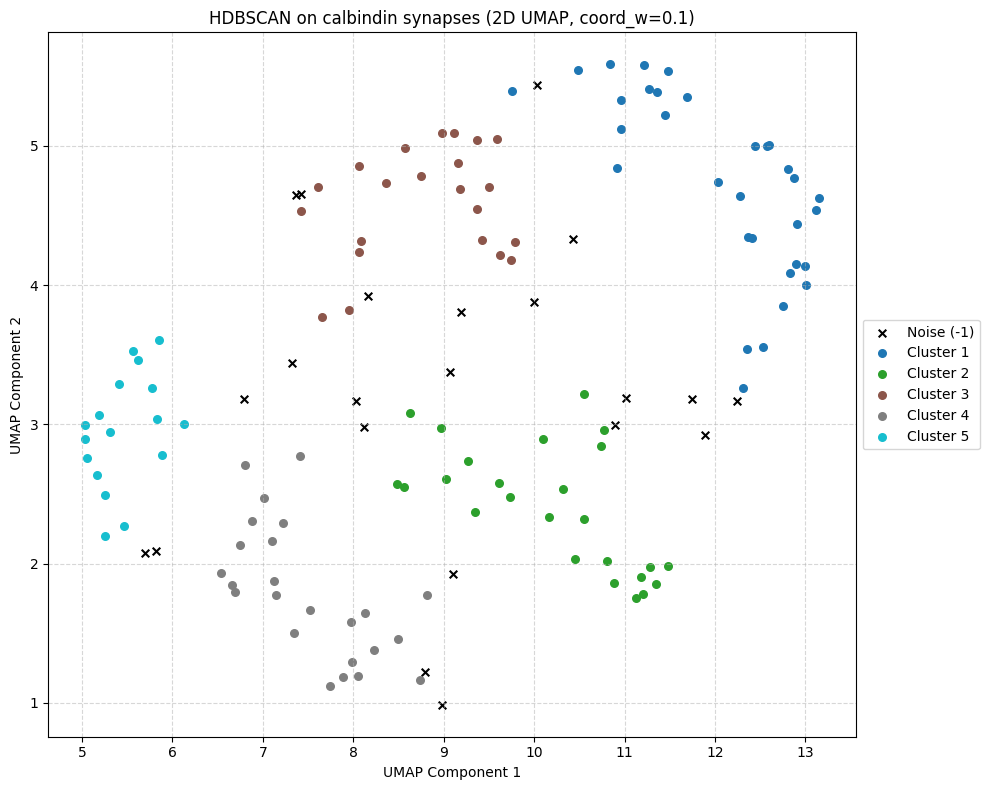

In [44]:
plot_hdbscan_umap_clusters(
    df_cluster,
    title="HDBSCAN on calbindin synapses (2D UMAP, coord_w=0.1)"
)

#### IV.1.10.4 **Clustering of calretinin-immunopositive ('cr') synapses with HDBSCAN**

* *min_cluster_size*: This value was selected relative to the sample size (n) to avoid identifying small, potentially spurious groups as clusters and to focus on robust, biologically meaningful structures.  

* *min_samples*: A lower min_samples value was used to accommodate lower local density and higher structural variability in the UMAP embedding.

In [45]:
df_cluster, clusterer = run_hdbscan_umap(
    umap_df_source=df_umap_cr,
    min_cluster_size=11,
    min_samples=3
)

cols = ['SynId', 'NeuronType', 'NeuronId', 'SynType', 'UMAP_1', 'UMAP_2', 'Cluster']
cr_cluster_final = df_cluster[cols].copy()
cr_cluster_final['clusterid'] = 'cr'

HDBSCAN: dim=3D, clusters=4, noise=3, min_cluster_size=11, min_samples=3


HDBSCAN visualisation of calretinin-immunopositive ('cr') synapses

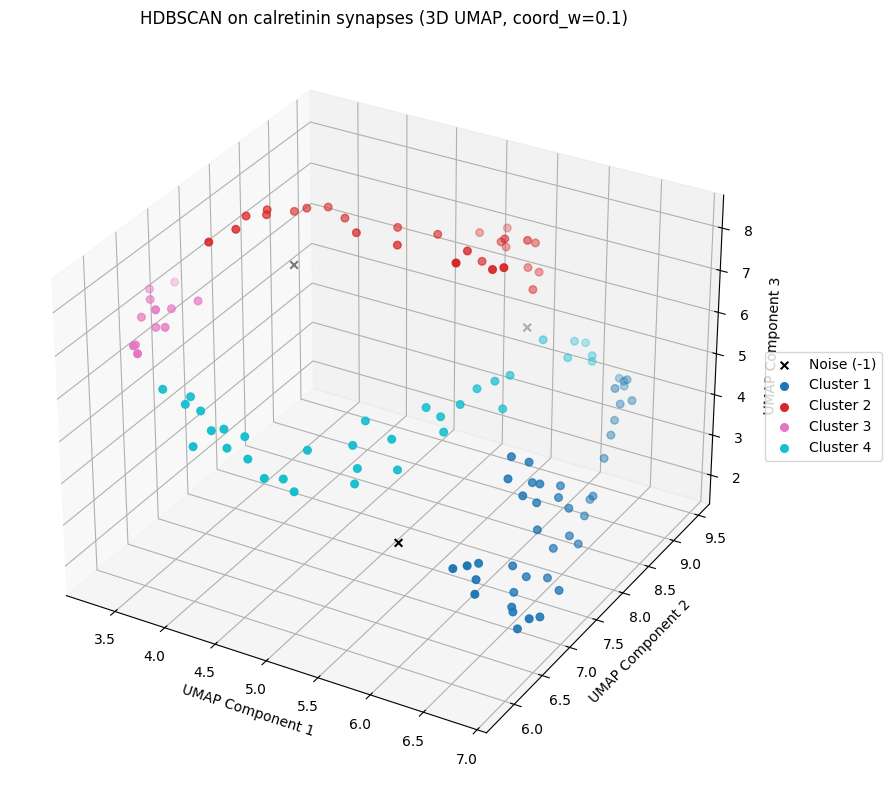

In [46]:
plot_hdbscan_umap_clusters(
    df_cluster,
    title="HDBSCAN on calretinin synapses (3D UMAP, coord_w=0.1)"
)

#### IV.1.10.5 **Clustering of parvalbumin-immunopositive ('pv') synapses with HDBSCAN**

* *min_cluster_size*: This value was selected relative to the sample size (n) to avoid identifying small, potentially spurious groups as clusters and to focus on robust, biologically meaningful structures.  

* *min_samples*: A lower min_samples value was used to accommodate lower local density and higher structural variability in the UMAP embedding.

In [47]:
df_cluster, clusterer = run_hdbscan_umap(
    umap_df_source=df_umap_pv,
    min_cluster_size=30,
    min_samples=7
)

cols = ['SynId', 'NeuronType', 'NeuronId', 'SynType', 'UMAP_1', 'UMAP_2', 'Cluster']
pv_cluster_final = df_cluster[cols].copy()
pv_cluster_final['clusterid'] = 'pv'

HDBSCAN: dim=2D, clusters=4, noise=43, min_cluster_size=30, min_samples=7


HDBSCAN visualisation of parvalbumin-immunopositive ('pv') synapses

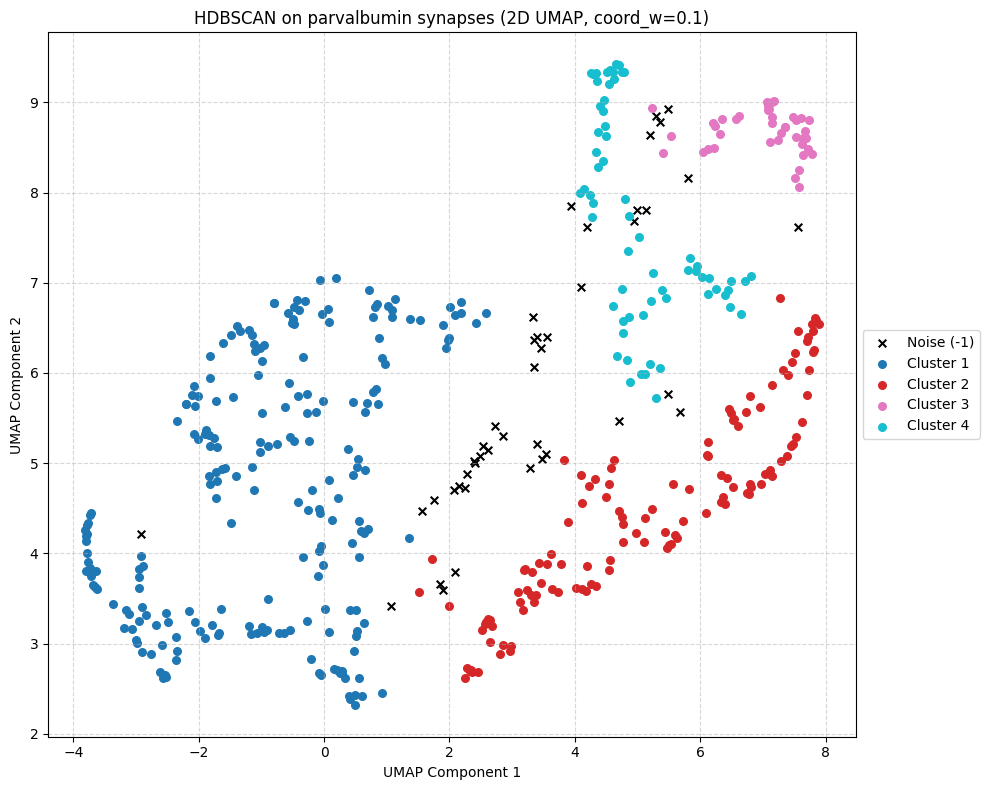

In [48]:
plot_hdbscan_umap_clusters(
    df_cluster,
    title="HDBSCAN on parvalbumin synapses (2D UMAP, coord_w=0.1)"
)

### IV.2 Saving final results

UMAP_1 and UMAP_2 values are used as input features for subsequent predictive models to classify new synapses.

In [49]:
dfs = [
    as_cluster_final,
    ss_cluster_final,
    cb_cluster_final,
    cr_cluster_final,
    pv_cluster_final
]

synapse_cluster_result = pd.concat(dfs, axis=0, ignore_index=True)

synapse_cluster_result.to_csv("neuron_synapse_clustering_HDBSCAN_result.csv", index=False)
synapse_cluster_result.to_excel("neuron_synapse_clustering_HDBSCAN_result.xlsx", index=False)

In [50]:
synapse_cluster_result.head()

,SynId,NeuronType,NeuronId,SynType,UMAP_1,UMAP_2,Cluster,clusterid
0,1,calbindin,cb1,as,8.397103,7.396665,4,as
1,2,calbindin,cb1,as,9.660243,3.746588,3,as
2,3,calbindin,cb1,as,7.106577,7.557750,4,as
3,6,calbindin,cb1,as,11.063272,5.086889,3,as
4,9,calbindin,cb1,as,7.563055,7.934532,4,as


In [51]:
synapse_cluster_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1496 entries, 0 to 1495
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SynId       1496 non-null   int64  
 1   NeuronType  1496 non-null   object 
 2   NeuronId    1496 non-null   object 
 3   SynType     1496 non-null   object 
 4   UMAP_1      1496 non-null   float32
 5   UMAP_2      1496 non-null   float32
 6   Cluster     1496 non-null   int64  
 7   clusterid   1496 non-null   object 
dtypes: float32(2), int64(2), object(4)
memory usage: 81.9+ KB


## V. Results and Future Directions

Using UMAP-based embedding followed by HDBSCAN clustering, well-separated
clusters were identified across both primary synapse types ('as', 'ss')
and individual neuronal types ('cb', 'cr', 'pv'):

- Excitatory ('as') synapses: 4 clusters  
- Inhibitory ('ss') synapses: 4 clusters  
- Calbindin ('cb') synapses: 5 clusters  
- Calretinin ('cr') synapses: 4 clusters  
- Parvalbumin ('pv') synapses: 4 clusters  

In the next phase of the project, the learned UMAP embedding and cluster
assignments will be used as pseudo-labels to develop a stable, cluster-based
classification framework for assigning newly observed synapses to existing
spatial clusters.